In [ ]:
import os
from google.colab import drive
import pickle
import joblib

import time
import numpy as np
import random

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

import tensorflow as tf
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import *
import cv2

# Data preparation

In [ ]:
# Define the function to load images
# ...
def load_images(CURRENT, CONTENTS, CATEGORIES):
    CNT_IMG = []
    for content in CONTENTS:
        for category in CATEGORIES:
            Path = os.path.join(CURRENT, content + '-' + category)
            if not os.path.exists(Path):
                print(f"Path does not exist: {Path}")
                continue
            for i, file in enumerate(os.listdir(Path)):
                img_array = cv2.imread(os.path.join(Path, file))  # 옵션을 제거하여 컬러 이미지로 읽기
                if img_array is None:
                    print(f"Could not read image: {os.path.join(Path, file)}")
                    continue
                CNT_IMG.append([img_array, CONTENTS.index(content), CATEGORIES.index(category), file])
    return CNT_IMG

# ...


# Load data
drive.mount('/content/drive')
# CURRENT = './CNT/'
CURRENT = '/content/drive/My Drive/CNT/'  # Have to change path according to your file structure
CONTENTS = ['0','0.05', '0.1', '0.2', '0.4']  # CNT Powder Content
METHODS = ['Shear', 'Sonic']
CNT_IMG = load_images(CURRENT, CONTENTS, METHODS)
print(f"Number of images loaded: {len(CNT_IMG)}")

In [ ]:
with open('/content/drive/My Drive/CNT_IMG_color.pkl', 'wb') as file:
    pickle.dump(CNT_IMG, file)

In [ ]:
# Load data
drive.mount('/content/drive')
with open('/content/drive/My Drive/MSML/CNT/CNT_IMG_color.pkl', 'rb') as file:
    CNT_IMG = pickle.load(file)

Mounted at /content/drive


# Preprocessing

## Split Data

Divide into small sizes and split into train and test datasets

In [ ]:
SMALL_IMG = []
# res = 0.188 # 0.188um/px
# 360.96 um x 203.04um
n_row = 3
n_col = 5
for img_array, content, method, name in CNT_IMG:
    for i in range(n_row):
        for k in range(n_col):
            height = int(img_array.shape[0]/n_row)
            width = int(img_array.shape[1]/n_col)
            small_img = img_array[i*height:(i+1)*height, k*width:(k+1)*width]
            SMALL_IMG.append([small_img, content, method, name])


labels_content = [img[1] for img in SMALL_IMG]
labels_method = [img[2] for img in SMALL_IMG]

labels_content = np.array(labels_content)
labels_method = np.array(labels_method)


In [ ]:
# Shuffle images to be trained well
random.seed(42)
random.shuffle(SMALL_IMG)

trainN = int(len(SMALL_IMG)*0.85)
print(trainN)

Train_Data = SMALL_IMG[:trainN]
Test_Data = SMALL_IMG[trainN:]

x_train = []
y_train = []  # second label, CNT powder content
y_train_method = []


for img_array, content, label, name in Train_Data:
    x_train.append(img_array)
    y_train.append(content)
    y_train_method.append(label)

# Change List to Numpy
x_train = np.array(x_train).reshape(trainN, height, width, 3) # (instances, height, width, depth)
y_train = np.array(y_train)
y_train_method = np.array(y_train_method)

print(x_train.shape, y_train.shape, y_train_method.shape)


x_test = []
y_test = []
y_test_method = []

for img_array, content, label, name in Test_Data:
    x_test.append(img_array)
    y_test.append(content)
    y_test_method.append(label)

x_test = np.array(x_test).reshape(-1, height, width, 3)
y_test = np.array(y_test)
y_test_method = np.array(y_test_method)

print(x_test.shape, y_test.shape)

4590
(4590, 360, 384, 3) (4590,) (4590,)
(810, 360, 384, 3) (810,)


## Convert to Histogram

In [ ]:
def compute_histogram(img, bins=256):
    # Compute histogram for each channel (R, G, B)
    hist_r = cv2.calcHist([img], [0], None, [bins], [0, 256]).flatten()
    hist_g = cv2.calcHist([img], [1], None, [bins], [0, 256]).flatten()
    hist_b = cv2.calcHist([img], [2], None, [bins], [0, 256]).flatten()
    # Stack histograms to create a "histogram image"
    hist_img = np.stack([hist_r, hist_g, hist_b], axis=-1)
    # Normalize histogram
    hist_img = hist_img / hist_img.sum()
    return hist_img

# Compute histograms for the scaled images
x_histo_train = np.array([compute_histogram(img) for img in x_train])
x_histo_test = np.array([compute_histogram(img) for img in x_test])

In [ ]:
print(x_histo_train.shape, y_train.shape)
x_histo_train[0]
x_histo_test[0]

(4590, 256, 3) (4590,)


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000

In [ ]:
# 채널별로 최소 및 최대값을 구합니다
min_vals = x_train.min(axis=(0,1,2), keepdims=False)
max_vals = x_train.max(axis=(0,1,2), keepdims=False)

In [ ]:
max_vals

array([255, 250, 255], dtype=uint8)

## Check for Robust

In [ ]:
# Function to adjust V channel in HSV space with random adjustment
def adjust_v_channel_randomly(img):
    adjustment_value = random.randint(-5, 5)  # Random value between -10 and 10
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    v = np.clip(v + adjustment_value, 0, 255) # Adjust V channel and ensure the values are within [0, 255]

    adjusted_hsv = np.dstack((h, s, v)).astype('uint8')
    adjusted_img = cv2.cvtColor(adjusted_hsv, cv2.COLOR_HSV2BGR)
    return adjusted_img

# Apply random V channel adjustment to test images
x_test_adjusted_random = np.array([adjust_v_channel_randomly(img) for img in x_test])

# Compute histograms for the randomly adjusted images
x_histo_test_adjusted_random = np.array([compute_histogram(img) for img in x_test_adjusted_random])

In [ ]:
with open('/content/drive/My Drive/x_test_adjusted_random.pkl', 'wb') as file:
    pickle.dump(x_test_adjusted_random, file)

## One-hot Encoding

In [ ]:
def to_one_hot(labels, dimension=5):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

y_train = to_one_hot(y_train) # Transformation of train label vector
y_test = to_one_hot(y_test)   # Transformation of test label vector

In [ ]:
x_histo = x_histo_train.reshape(x_histo_train.shape[0],-1)
x_histo_test = x_histo_test.reshape(x_histo_test.shape[0],-1)

# Modelling

## ML

### 1. KNN

#### GridSearch

In [ ]:
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],  # 이웃 수
    'knn__weights': ['uniform', 'distance'],  # 가중치 유형
    'knn__metric': ['euclidean', 'manhattan']  # 거리 측정 유형
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

grid_content = GridSearchCV(pipe, param_grid, cv=5)
grid_method = GridSearchCV(pipe, param_grid, cv=5)

In [ ]:
grid_content.fit(x_histo, y_train.argmax(axis=1))
print(f"Best parameters for CONTENT: {grid_content.best_params_}")
print(f"Best cross-validation score for CONTENT: {grid_content.best_score_}")

grid_method.fit(x_histo, y_train_method)
print(f"Best parameters for METHOD: {grid_method.best_params_}")
print(f"Best cross-validation score for METHOD: {grid_method.best_score_}")

best_knn_content = grid_content.best_estimator_
best_knn_method = grid_method.best_estimator_

content_accuracy = accuracy_score(y_test.argmax(axis=1), best_knn_content.predict(x_histo_test))
method_accuracy = accuracy_score(y_test_method, best_knn_method.predict(x_histo_test))

print(f"Test accuracy for CONTENT: {content_accuracy}")
print(f"Test accuracy for METHOD: {method_accuracy}")

Best parameters for CONTENT: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Best cross-validation score for CONTENT: 0.8858387799564269
Best parameters for METHOD: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
Best cross-validation score for METHOD: 0.9605664488017428
Test accuracy for CONTENT: 0.8753086419753087
Test accuracy for METHOD: 0.9604938271604938


#### Evaluate

In [ ]:
joblib.dump(best_knn_content, '/content/drive/My Drive/MSML/CNT/Results/RGB/best_knn_content_model.joblib')
joblib.dump(best_knn_method, '/content/drive/My Drive/MSML/CNT/Results/RGB/best_knn_method_model.joblib')

['/content/drive/My Drive/MSML/CNT/Results/RGB/best_knn_method_model.joblib']

In [ ]:
loaded_knn_content_model = joblib.load('/content/drive/My Drive/MSML/CNT/Results/RGB/best_knn_content_model.joblib')
loaded_knn_method_model = joblib.load('/content/drive/My Drive/MSML/CNT/Results/RGB/best_knn_method_model.joblib')

loaded_content_accuracy = accuracy_score(y_test.argmax(axis=1), loaded_knn_content_model.predict(x_histo_test))
loaded_method_accuracy = accuracy_score(y_test_method, loaded_knn_method_model.predict(x_histo_test))
print(f"Test accuracy for loaded CONTENT model: {loaded_content_accuracy}")
print(f"Test accuracy for loaded METHOD model: {loaded_method_accuracy}")

Test accuracy for loaded CONTENT model: 0.8753086419753087
Test accuracy for loaded METHOD model: 0.9604938271604938


In [ ]:
y_pred_content_knn = loaded_knn_content_model.predict(x_histo_test)
y_pred_method_knn = loaded_knn_method_model.predict(x_histo_test)

print("KNN Model Metrics:")
print(f"CONTENT F1 Score: {f1_score(y_test.argmax(axis=1), y_pred_content_knn, average='macro')}")
print(f"METHOD F1 Score: {f1_score(y_test_method, y_pred_method_knn, average=None)}")
print(f"CONTENT Precision: {precision_score(y_test.argmax(axis=1), y_pred_content_knn, average='macro')}")
print(f"METHOD Precision: {precision_score(y_test_method, y_pred_method_knn, average=None)}")
print(f"CONTENT Recall: {recall_score(y_test.argmax(axis=1), y_pred_content_knn, average='macro')}")
print(f"METHOD Recall: {recall_score(y_test_method, y_pred_method_knn, average=None)}")
print(f"CONTENT Confusion Matrix:\n{confusion_matrix(y_test.argmax(axis=1), y_pred_content_knn)}")
print(f"METHOD Confusion Matrix:\n{confusion_matrix(y_test_method, y_pred_method_knn)}")

KNN Model Metrics:
CONTENT F1 Score: 0.8782922032465391
METHOD F1 Score: [0.96544276 0.95389049]
CONTENT Precision: 0.8751234562767876
METHOD Precision: [0.96129032 0.95942029]
CONTENT Recall: 0.8823086555896719
METHOD Recall: [0.96963124 0.94842407]
CONTENT Confusion Matrix:
[[ 88   4   3   0   0]
 [  1 163   7   1   1]
 [ 13  10 151  23   0]
 [  0   0  26 139   3]
 [  0   3   1   5 168]]
METHOD Confusion Matrix:
[[447  14]
 [ 18 331]]


#### Plot

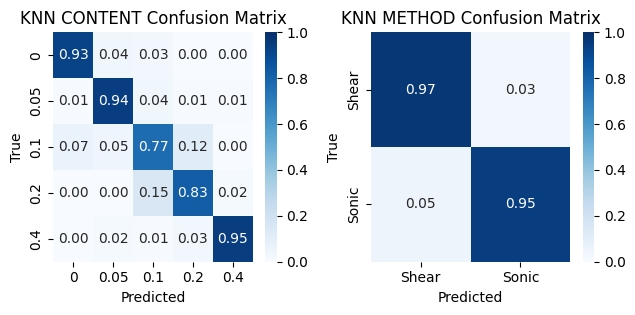

In [ ]:
cm_content_knn = confusion_matrix(y_test.argmax(axis=1), y_pred_content_knn)
cm_method_knn = confusion_matrix(y_test_method, y_pred_method_knn)

cm_content_knn_norm = cm_content_knn.astype('float') / cm_content_knn.sum(axis=1)[:, np.newaxis]
cm_method_knn_norm = cm_method_knn.astype('float') / cm_method_knn.sum(axis=1)[:, np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.25))

CONTENTS = [0, 0.05, 0.1, 0.2, 0.4]
METHODS = ['Shear', 'Sonic']

# KNN CONTENT 혼동 행렬을 시각화합니다.
sns.heatmap(cm_content_knn_norm, annot=True, fmt=".2f", ax=axs[0], cmap='Blues', xticklabels=CONTENTS, yticklabels=CONTENTS, vmin=0, vmax=1)
axs[0].set_title('KNN CONTENT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

# KNN METHOD 혼동 행렬을 시각화합니다.
sns.heatmap(cm_method_knn_norm, annot=True, fmt=".2f", ax=axs[1], cmap='Blues', xticklabels=METHODS, yticklabels=METHODS, vmin=0, vmax=1)
axs[1].set_title('KNN METHOD Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
fig.savefig('/content/drive/My Drive/MSML/CNT/Results/RGB/confusion_matrix_knn.svg', format='svg')

### 2. SVC

#### GridSearch

In [ ]:
param_grid = {
    'svm__C': [0.1, 1, 10],  # Regularization parameter
    'svm__kernel': ['linear', 'rbf'],  # Kernel type
    'svm__gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

pipe = Pipeline([
    ('scaler', StandardScaler()),  # 데이터 스케일링
    ('svm', SVC())  # SVM 분류기
])

grid_content = GridSearchCV(pipe, param_grid, cv=5)
grid_method = GridSearchCV(pipe, param_grid, cv=5)

In [ ]:
grid_content.fit(x_histo, y_train.argmax(axis=1))
print(f"Best parameters for CONTENT: {grid_content.best_params_}")
print(f"Best cross-validation score for CONTENT: {grid_content.best_score_}")

grid_method.fit(x_histo, y_train_method)
print(f"Best parameters for METHOD: {grid_method.best_params_}")
print(f"Best cross-validation score for METHOD: {grid_method.best_score_}")

best_svm_content = grid_content.best_estimator_
best_svm_method = grid_method.best_estimator_

content_accuracy = accuracy_score(y_test.argmax(axis=1), best_svm_content.predict(x_histo_test))
method_accuracy = accuracy_score(y_test_method, best_svm_method.predict(x_histo_test))

print(f"Test accuracy for CONTENT: {content_accuracy}")
print(f"Test accuracy for METHOD: {method_accuracy}")

#### Evaluate

In [ ]:
loaded_svm_content_model = joblib.load('/content/drive/My Drive/MSML/CNT/Results/RGB/best_svm_content_model.joblib')
loaded_svm_method_model = joblib.load('/content/drive/My Drive/MSML/CNT/Results/RGB/best_svm_method_model.joblib')

loaded_content_accuracy = accuracy_score(y_test.argmax(axis=1), loaded_svm_content_model.predict(x_histo_test))
loaded_method_accuracy = accuracy_score(y_test_method, loaded_svm_method_model.predict(x_histo_test))
print(f"Test accuracy for loaded CONTENT model: {loaded_content_accuracy}")
print(f"Test accuracy for loaded METHOD model: {loaded_method_accuracy}")

Test accuracy for loaded CONTENT model: 0.8938271604938272
Test accuracy for loaded METHOD model: 0.9691358024691358


In [ ]:
y_pred_content_svm = loaded_svm_content_model.predict(x_histo_test)
y_pred_method_svm = loaded_svm_method_model.predict(x_histo_test)

print("SVM Model Metrics:")
print(f"CONTENT F1 Score: {f1_score(y_test.argmax(axis=1), y_pred_content_svm, average='macro')}")
print(f"METHOD F1 Score: {f1_score(y_test_method, y_pred_method_svm, average=None)}")
print(f"CONTENT Precision: {precision_score(y_test.argmax(axis=1), y_pred_content_svm, average='macro')}")
print(f"METHOD Precision: {precision_score(y_test_method, y_pred_method_svm, average=None)}")
print(f"CONTENT Recall: {recall_score(y_test.argmax(axis=1), y_pred_content_svm, average='macro')}")
print(f"METHOD Recall: {recall_score(y_test_method, y_pred_method_svm, average=None)}")
print(f"CONTENT Confusion Matrix:\n{confusion_matrix(y_test.argmax(axis=1), y_pred_content_svm)}")
print(f"METHOD Confusion Matrix:\n{confusion_matrix(y_test_method, y_pred_method_svm)}")

SVM Model Metrics:
CONTENT F1 Score: 0.8971616887126382
METHOD F1 Score: [0.97291441 0.96413199]
CONTENT Precision: 0.8929439012361357
METHOD Precision: [0.97186147 0.96551724]
CONTENT Recall: 0.9027607591342601
METHOD Recall: [0.97396963 0.96275072]
CONTENT Confusion Matrix:
[[ 92   2   1   0   0]
 [  2 163   5   2   1]
 [  9  10 155  22   1]
 [  0   0  20 140   8]
 [  0   1   0   2 174]]
METHOD Confusion Matrix:
[[449  12]
 [ 13 336]]


#### Plot

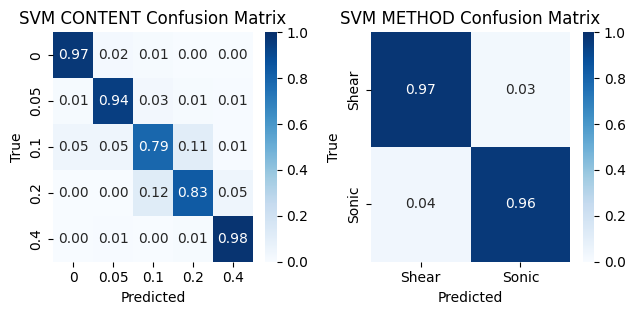

In [ ]:
# 혼동 행렬을 계산합니다.
cm_content_svm = confusion_matrix(y_test.argmax(axis=1), y_pred_content_svm)
cm_method_svm = confusion_matrix(y_test_method, y_pred_method_svm)

# 혼동 행렬을 정규화합니다.
cm_content_svm_norm = cm_content_svm.astype('float') / cm_content_svm.sum(axis=1)[:, np.newaxis]
cm_method_svm_norm = cm_method_svm.astype('float') / cm_method_svm.sum(axis=1)[:, np.newaxis]

# 시각화를 위한 설정입니다.
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.25))

CONTENTS = [0, 0.05, 0.1, 0.2, 0.4]
METHODS = ['Shear', 'Sonic']

# SVM CONTENT 혼동 행렬을 시각화합니다.
sns.heatmap(cm_content_svm_norm, annot=True, fmt=".2f", ax=axs[0], cmap='Blues', xticklabels=CONTENTS, yticklabels=CONTENTS, vmin=0, vmax=1)
axs[0].set_title('SVM CONTENT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

# SVM METHOD 혼동 행렬을 시각화합니다.
sns.heatmap(cm_method_svm_norm, annot=True, fmt=".2f", ax=axs[1], cmap='Blues', xticklabels=METHODS, yticklabels=METHODS, vmin=0, vmax=1)
axs[1].set_title('SVM METHOD Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
fig.savefig('/content/drive/My Drive/MSML/CNT/Results/RGB/confusion_matrix_svm.svg', format='svg')

### 3. RF

Try default model

In [ ]:
rfc_content = RandomForestClassifier(random_state=42)
rfc_method = RandomForestClassifier(random_state=42)

rfc_content.fit(x_histo, y_train.argmax(axis=1))
rfc_method.fit(x_histo, y_train_method)

content_accuracy = accuracy_score(y_test.argmax(axis=1), rfc_content.predict(x_histo_test))
method_accuracy = accuracy_score(y_test_method, rfc_method.predict(x_histo_test))

print(f"Test accuracy for CONTENT: {content_accuracy}")
print(f"Test accuracy for METHOD: {method_accuracy}")

Test accuracy for CONTENT: 0.9148148148148149
Test accuracy for METHOD: 0.971604938271605


#### GridSearch

In [ ]:
params = { 'n_estimators' : [100, 200],
           'max_depth' : [5, 10, 15, 20],
           'min_samples_leaf' : [4, 6, 8, 12, 16],
           'min_samples_split' : [4, 6, 8, 12, 16]
            }

grid_content = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5, n_jobs=-1)
grid_method = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5, n_jobs=-1)

In [ ]:
grid_content.fit(x_histo, y_train.argmax(axis=1))
print(f"Best parameters for CONTENT: {grid_content.best_params_}")
print(f"Best cross-validation score for CONTENT: {grid_content.best_score_}")

grid_method.fit(x_histo, y_train_method)
print(f"Best parameters for METHOD: {grid_method.best_params_}")
print(f"Best cross-validation score for METHOD: {grid_method.best_score_}")

best_rf_content = grid_content.best_estimator_
best_rf_method = grid_method.best_estimator_

content_accuracy = accuracy_score(y_test.argmax(axis=1), best_rf_content.predict(x_histo_test))
method_accuracy = accuracy_score(y_test_method, best_rf_method.predict(x_histo_test))

print(f"Test accuracy for CONTENT: {content_accuracy}")
print(f"Test accuracy for METHOD: {method_accuracy}")

Best parameters for CONTENT: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 200}
Best cross-validation score for CONTENT: 0.9065359477124183
Best parameters for METHOD: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 200}
Best cross-validation score for METHOD: 0.9688453159041395
Test accuracy for CONTENT: 0.908641975308642
Test accuracy for METHOD: 0.9728395061728395


In [ ]:
joblib.dump(best_rf_content, '/content/drive/My Drive/MSML/CNT/Results/RGB/best_rf_content_model.joblib')
joblib.dump(best_rf_method, '/content/drive/My Drive/MSML/CNT/Results/RGB/best_rf_method_model.joblib')

['/content/drive/My Drive/MSML/CNT/Results/RGB/best_rf_method_model.joblib']

#### Evaluate

In [ ]:
loaded_rf_content_model = joblib.load('/content/drive/My Drive/MSML/CNT/Results/RGB/best_rf_content_model.joblib')
loaded_rf_method_model = joblib.load('/content/drive/My Drive/MSML/CNT/Results/RGB/best_rf_method_model.joblib')

loaded_content_accuracy = accuracy_score(y_test.argmax(axis=1), loaded_rf_content_model.predict(x_histo_test))
loaded_method_accuracy = accuracy_score(y_test_method, loaded_rf_method_model.predict(x_histo_test))
print(f"Test accuracy for loaded CONTENT model: {loaded_content_accuracy}")
print(f"Test accuracy for loaded METHOD model: {loaded_method_accuracy}")

Test accuracy for loaded CONTENT model: 0.908641975308642
Test accuracy for loaded METHOD model: 0.9728395061728395


In [ ]:
y_pred_content_rf = loaded_rf_content_model.predict(x_histo_test)
y_pred_method_rf = loaded_rf_method_model.predict(x_histo_test)

print("RF Model Metrics:")
print(f"CONTENT F1 Score: {f1_score(y_test.argmax(axis=1), y_pred_content_rf, average='macro')}")
print(f"METHOD F1 Score: {f1_score(y_test_method, y_pred_method_rf, average=None)}")
print(f"CONTENT Precision: {precision_score(y_test.argmax(axis=1), y_pred_content_rf, average='macro')}")
print(f"METHOD Precision: {precision_score(y_test_method, y_pred_method_rf, average=None)}")
print(f"CONTENT Recall: {recall_score(y_test.argmax(axis=1), y_pred_content_rf, average='macro')}")
print(f"METHOD Recall: {recall_score(y_test_method, y_pred_method_rf, average=None)}")
print(f"CONTENT Confusion Matrix:\n{confusion_matrix(y_test.argmax(axis=1), y_pred_content_rf)}")
print(f"METHOD Confusion Matrix:\n{confusion_matrix(y_test_method, y_pred_method_rf)}")

RF Model Metrics:
CONTENT F1 Score: 0.9151977139693237
METHOD F1 Score: [0.97613883 0.96848138]
CONTENT Precision: 0.9149630670882407
METHOD Precision: [0.97613883 0.96848138]
CONTENT Recall: 0.9155036503695662
METHOD Recall: [0.97613883 0.96848138]
CONTENT Confusion Matrix:
[[ 92   2   1   0   0]
 [  1 162   7   2   1]
 [  2  11 164  20   0]
 [  0   1  22 144   1]
 [  0   1   0   2 174]]
METHOD Confusion Matrix:
[[450  11]
 [ 11 338]]


#### Plot

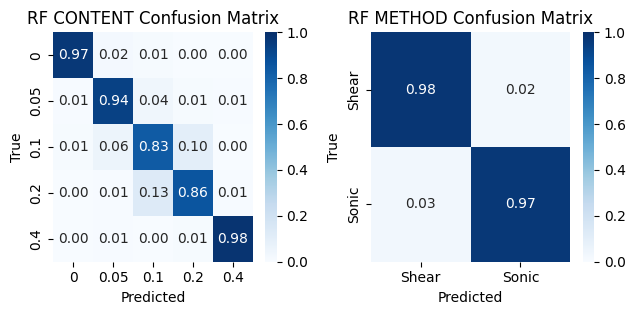

In [ ]:
# 혼동 행렬을 계산합니다.
cm_content_rf = confusion_matrix(y_test.argmax(axis=1), y_pred_content_rf)
cm_method_rf = confusion_matrix(y_test_method, y_pred_method_rf)

# 혼동 행렬을 정규화합니다.
cm_content_rf_norm = cm_content_rf.astype('float') / cm_content_rf.sum(axis=1)[:, np.newaxis]
cm_method_rf_norm = cm_method_rf.astype('float') / cm_method_rf.sum(axis=1)[:, np.newaxis]

# 시각화를 위한 설정입니다.
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.25))

CONTENTS = [0, 0.05, 0.1, 0.2, 0.4]
METHODS = ['Shear', 'Sonic']

# RF CONTENT 혼동 행렬을 시각화합니다.
sns.heatmap(cm_content_rf_norm, annot=True, fmt=".2f", ax=axs[0], cmap='Blues', xticklabels=CONTENTS, yticklabels=CONTENTS, vmin=0, vmax=1)
axs[0].set_title('RF CONTENT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

# RF METHOD 혼동 행렬을 시각화합니다.
sns.heatmap(cm_method_rf_norm, annot=True, fmt=".2f", ax=axs[1], cmap='Blues', xticklabels=METHODS, yticklabels=METHODS, vmin=0, vmax=1)
axs[1].set_title('RF METHOD Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
fig.savefig('/content/drive/My Drive/MSML/CNT/Results/RGB/confusion_matrix_rf.svg', format='svg')

### 4. LGB

Try default model

In [ ]:
lgbm_content = lgb.LGBMClassifier(random_state=42)
lgbm_method = lgb.LGBMClassifier(random_state=42)

lgbm_content.fit(x_histo, y_train.argmax(axis=1))
lgbm_method.fit(x_histo, y_train_method)

content_accuracy = accuracy_score(y_test.argmax(axis=1), lgbm_content.predict(x_histo_test))
method_accuracy = accuracy_score(y_test_method, lgbm_method.predict(x_histo_test))

print(f"Test accuracy for CONTENT: {content_accuracy}")
print(f"Test accuracy for METHOD: {method_accuracy}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121384
[LightGBM] [Info] Number of data points in the train set: 4590, number of used features: 630
[LightGBM] [Info] Start training from score -2.207077
[LightGBM] [Info] Start training from score -1.497238
[LightGBM] [Info] Start training from score -1.520885
[LightGBM] [Info] Start training from score -1.492381
[LightGBM] [Info] Start training from score -1.501141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2051, number of negative: 2539
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121384
[LightGBM] [Info] Number of data points in the train set: 4590, number of used features: 630
[Lig

#### GridSearch

In [ ]:
params = {
    "max_depth": [25, 50, -1],
    "num_leaves": [20, 31, 40],
}

# GridSearchCV 정의
grid_content = GridSearchCV(lgb.LGBMClassifier(random_state=42, verbose=2), params, cv=3, n_jobs=-1, verbose=3)
grid_method = GridSearchCV(lgb.LGBMClassifier(random_state=42, verbose=2), params, cv=3, n_jobs=-1, verbose=3)

In [ ]:
grid_content.fit(x_histo, y_train.argmax(axis=1))
print(f"Best parameters for CONTENT: {grid_content.best_params_}")
print(f"Best cross-validation score for CONTENT: {grid_content.best_score_}")

grid_method.fit(x_histo, y_train_method)
print(f"Best parameters for METHOD: {grid_method.best_params_}")
print(f"Best cross-validation score for METHOD: {grid_method.best_score_}")

best_lgb_content = grid_content.best_estimator_
best_lgb_method = grid_method.best_estimator_

content_accuracy = accuracy_score(y_test.argmax(axis=1), best_lgb_content.predict(x_histo_test))
method_accuracy = accuracy_score(y_test_method, best_lgb_method.predict(x_histo_test))

print(f"Test accuracy for CONTENT: {content_accuracy}")
print(f"Test accuracy for METHOD: {method_accuracy}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.870960
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.297307
[LightGBM] [Debug] init for col-wise cost 0.003710 seconds, init for row-wise cost 0.021151 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121384
[LightGBM] [Info] Number of data points in the train set: 4590, number of used features: 630
[LightGBM] [Info] Start training from score -2.207077
[LightGBM] [Info] Start training from score -1.497238
[LightGBM] [Info] Start training from score -1.520885
[LightGBM] [Info] Start training from score -1.492381
[LightGBM] [Info] Start training from score -1.501141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves =

In [ ]:
joblib.dump(best_lgb_content, '/content/drive/My Drive/MSML/CNT/Results/RGB/best_lgb_content_model.joblib')
joblib.dump(best_lgb_method, '/content/drive/My Drive/MSML/CNT/Results/RGB/best_lgb_method_model.joblib')

['/content/drive/My Drive/MSML/CNT/Results/RGB/best_lgb_method_model.joblib']

#### Evaluate

In [ ]:
lgb_content_model = joblib.load('/content/drive/My Drive/MSML/CNT/Results/RGB/best_lgb_content_model.joblib')
lgb_method_model = joblib.load('/content/drive/My Drive/MSML/CNT/Results/RGB/best_lgb_method_model.joblib')

content_accuracy = accuracy_score(y_test.argmax(axis=1), lgb_content_model.predict(x_histo_test))
method_accuracy = accuracy_score(y_test_method, lgb_method_model.predict(x_histo_test))
print(f"Test accuracy for loaded CONTENT model: {content_accuracy}")
print(f"Test accuracy for loaded METHOD model: {method_accuracy}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Test accuracy for loaded CONTENT model: 0.9234567901234568
Test accuracy for loaded METHOD model: 0.9765432098765432


In [ ]:
y_pred_content_lgb = lgb_content_model.predict(x_histo_test)
y_pred_method_lgb = lgb_method_model.predict(x_histo_test)

print("LGB Model Metrics:")
print(f"CONTENT F1 Score: {f1_score(y_test.argmax(axis=1), y_pred_content_lgb, average='macro')}")
print(f"METHOD F1 Score: {f1_score(y_test_method, y_pred_method_lgb, average=None)}")
print(f"CONTENT Precision: {precision_score(y_test.argmax(axis=1), y_pred_content_lgb, average='macro')}")
print(f"METHOD Precision: {precision_score(y_test_method, y_pred_method_lgb, average=None)}")
print(f"CONTENT Recall: {recall_score(y_test.argmax(axis=1), y_pred_content_lgb, average='macro')}")
print(f"METHOD Recall: {recall_score(y_test_method, y_pred_method_lgb, average=None)}")
print(f"CONTENT Confusion Matrix:\n{confusion_matrix(y_test.argmax(axis=1), y_pred_content_lgb)}")
print(f"METHOD Confusion Matrix:\n{confusion_matrix(y_test_method, y_pred_method_lgb)}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
LGB Model Metrics:
CONTENT F1 Score: 0.9290602155773973
METHOD F1 Score: [0.97950378 0.97258297]
CONTENT Precision: 0.9294954538875512
METHOD Precision: [0.97424893 0.97965116]
CONTENT Recall: 0.9286690644181703
METHOD Recall: [0.98481562 0.96561605]
CONTENT Confusion Matrix:
[[ 92   2   1   0   0]
 [  0 164   6   2   1]
 [  2   8 170  17   0]
 [  0   1  18 148   1]
 [  0   1   1   1 174]]
METHOD Confusion Matrix:
[[454   7]
 [ 12 337]]


#### Plot

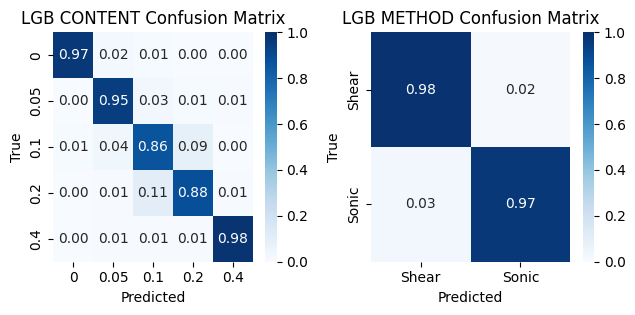

In [ ]:
# 혼동 행렬을 계산합니다.
cm_content_lgb = confusion_matrix(y_test.argmax(axis=1), y_pred_content_lgb)
cm_method_lgb = confusion_matrix(y_test_method, y_pred_method_lgb)

# 혼동 행렬을 정규화합니다.
cm_content_lgb_norm = cm_content_lgb.astype('float') / cm_content_lgb.sum(axis=1)[:, np.newaxis]
cm_method_lgb_norm = cm_method_lgb.astype('float') / cm_method_lgb.sum(axis=1)[:, np.newaxis]

# 시각화를 위한 설정입니다.
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.25))

CONTENTS = [0, 0.05, 0.1, 0.2, 0.4]
METHODS = ['Shear', 'Sonic']

# LGB CONTENT 혼동 행렬을 시각화합니다.
sns.heatmap(cm_content_lgb_norm, annot=True, fmt=".2f", ax=axs[0], cmap='Blues', xticklabels=CONTENTS, yticklabels=CONTENTS, vmin=0, vmax=1)
axs[0].set_title('LGB CONTENT Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

# LGB METHOD 혼동 행렬을 시각화합니다.
sns.heatmap(cm_method_lgb_norm, annot=True, fmt=".2f", ax=axs[1], cmap='Blues', xticklabels=METHODS, yticklabels=METHODS, vmin=0, vmax=1)
axs[1].set_title('LGB METHOD Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
fig.savefig('/content/drive/My Drive/MSML/CNT/Results/RGB/confusion_matrix_lgb.svg', format='svg')

## DL

### CNN Layers

In [ ]:
kernel_size = 7
# filters = [16, 32, 64]
# filters = [32, 64, 128]
filters = [64, 128, 256]

# Input Layer
input_tensor = Input(shape=(256, 3))

# Shared Layers
x = Conv1D(filters=filters[0], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(input_tensor)
x = Dropout(0.2)(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=filters[1], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = Conv1D(filters=filters[1], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
# x = Conv1D(filters=filters[1], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
# x = Dropout(0.2)(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=filters[2], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = Conv1D(filters=filters[2], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
# x = Conv1D(filters=filters[2], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
# x = Dropout(0.2)(x)
x = MaxPooling1D(pool_size=2)(x)

shared_output = Flatten()(x)

# Sonication Prediction
sonication_output = Dense(1, activation='sigmoid', name='sonication_output')(shared_output)

# Content Prediction
content_output = Dense(5, activation='softmax', name='content_output')(shared_output)

# # Construct the Model
model = Model(inputs=input_tensor, outputs=[sonication_output, content_output])

# Compile the Model
# Assuming primary focus is on 'content' prediction, we can adjust the loss weights accordingly.
WEIGHT = 0.5
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss={'sonication_output': 'binary_crossentropy', 'content_output': 'categorical_crossentropy'},
              loss_weights={'sonication_output': 1-WEIGHT, 'content_output': WEIGHT},
              metrics=['accuracy'])

model.summary()

### Train

In [ ]:
# ModelCheckpoint 콜백 설정
checkpoint_path = "/content/drive/My Drive/Results/RGB/best_cnn_model.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode='min'
)
# EarlyStopping 콜백 설정
early_stopping_callback = EarlyStopping(patience=20)

# Assuming you have corresponding labels for 'sonication' and 'content' in your dataset.
run_results = model.fit(
    x_histo_train,
    {'sonication_output': y_train_method, 'content_output': y_train},
    validation_split=0.15,
    batch_size=32,
    epochs=200,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

model_path = "/content/drive/My Drive/Results/RGB/cnn_model.h5"
model.save(model_path)
print(f"Model saved at {model_path}")

model_path = "/content/drive/My Drive/Results/RGB/best_cnn_model.pkl"
with open(model_path, "wb") as file:
    pickle.dump(run_results.history, file)

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 256, 3)]     0           []                               
                                                                                                  
 conv1d_134 (Conv1D)            (None, 256, 64)      1408        ['input_25[0][0]']               
                                                                                                  
 dropout_134 (Dropout)          (None, 256, 64)      0           ['conv1d_134[0][0]']             
                                                                                                  
 max_pooling1d_72 (MaxPooling1D  (None, 128, 64)     0           ['dropout_134[0][0]']            
 )                                                                                         

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


121/122 [============================>.] - ETA: 0s - loss: 0.5498 - sonication_output_loss: 0.2842 - content_output_loss: 0.8154 - sonication_output_accuracy: 0.8776 - content_output_accuracy: 0.6219
Epoch 1: val_loss improved from inf to 0.43235, saving model to /content/drive/My Drive/Results/RGB/best_cnn_model.h5
122/122 [==============================] - 7s 42ms/step - loss: 0.5493 - sonication_output_loss: 0.2848 - content_output_loss: 0.8137 - sonication_output_accuracy: 0.8775 - content_output_accuracy: 0.6224 - val_loss: 0.4324 - val_sonication_output_loss: 0.2279 - val_content_output_loss: 0.6368 - val_sonication_output_accuracy: 0.9086 - val_content_output_accuracy: 0.7518
Epoch 2/200
121/122 [============================>.] - ETA: 0s - loss: 0.3690 - sonication_output_loss: 0.1928 - content_output_loss: 0.5451 - sonication_output_accuracy: 0.9236 - content_output_accuracy: 0.7738
Epoch 2: val_loss improved from 0.43235 to 0.36956, saving model to /content/drive/My Drive/Resu

### Plot

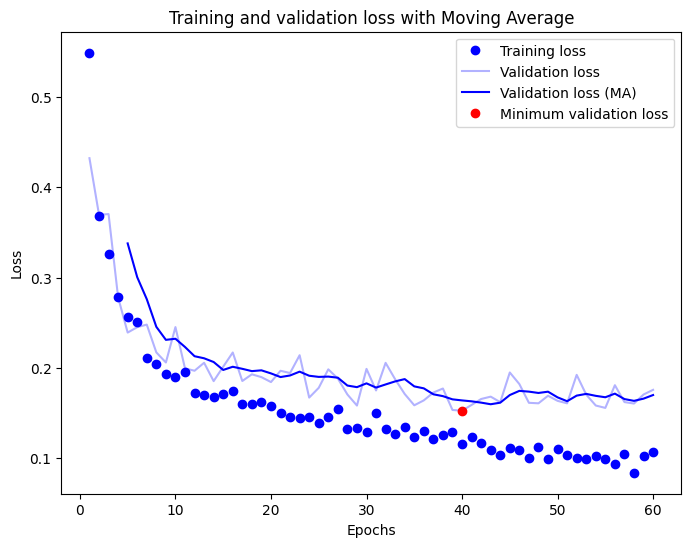

In [ ]:
# run_results는 fit 함수의 반환 값으로, 훈련의 히스토리 정보를 포함하고 있습니다.
history = run_results.history

# 손실 값 추출
train_loss = history['loss']
val_loss = history['val_loss']

# 에포크 번호
epochs = range(1, len(train_loss) + 1)
# 이동 평균을 계산하는 함수 정의
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 이동 평균 윈도우 사이즈 설정
window_size = 5

# 이동 평균 계산
val_loss_ma = moving_average(val_loss, window_size)

# 유효한 이동 평균 데이터에 해당하는 에포크 번호 조정
valid_epochs = range(window_size, len(train_loss) + 1)
# 최소 검증 손실 값과 해당 인덱스 찾기
min_val_loss_index = np.argmin(val_loss)
min_val_loss = val_loss[min_val_loss_index]

# 손실 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', alpha=0.3, label='Validation loss')
plt.plot(valid_epochs, val_loss_ma, 'b', label='Validation loss (MA)')

# 최소 검증 손실 지점 표시
plt.plot(min_val_loss_index + 1, min_val_loss, 'ro', label='Minimum validation loss')

plt.title('Training and validation loss with Moving Average')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('/content/drive/My Drive/Results/RGB/training_curve.svg', format='svg')
plt.show()

26/26 [==============================] - 0s 11ms/step
0.9739884393063584 0.9825072886297376 0.9656160458452722
0.9092233576293216 0.9100459470313679 0.908641975308642


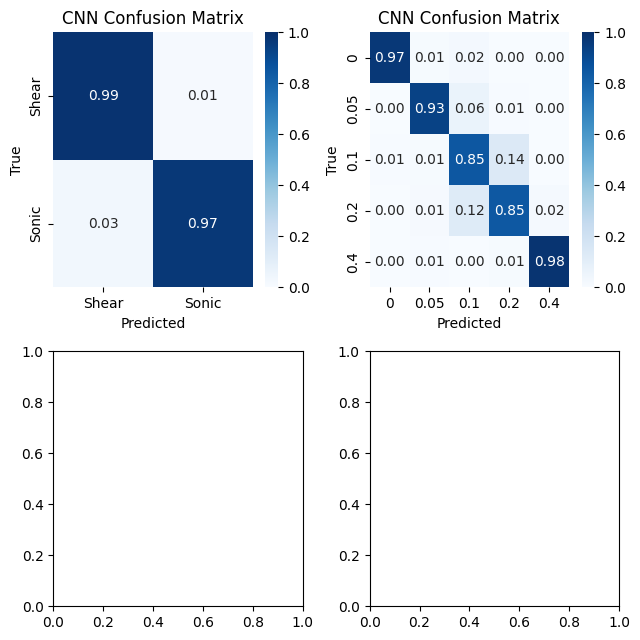

In [ ]:
# 저장된 모델을 불러옵니다.
# 모델 로드
model_path = "/content/drive/My Drive/Results/RGB/best_cnn_model.h5"

model = tf.keras.models.load_model(model_path)

# 모델을 사용하여 테스트 데이터에 대한 예측을 생성합니다.
predictions = model.predict(x_histo_test)

# 예측 결과를 분리합니다.
sonication_predictions, content_predictions = predictions



# 이진 분류 문제에 대한 지표를 계산합니다. (Sonication)
sonication_true = y_test_method
sonication_pred = (sonication_predictions > 0.5).astype(int)  # 시그모이드 출력을 이진 레이블로 변환

sonication_f1 = f1_score(sonication_true, sonication_pred)
sonication_precision = precision_score(sonication_true, sonication_pred)
sonication_recall = recall_score(sonication_true, sonication_pred)

# 다중 클래스 분류 문제에 대한 지표를 계산합니다. (Content)
content_true = np.argmax(y_test, axis=1)
content_pred = np.argmax(content_predictions, axis=1)

content_f1 = f1_score(content_true, content_pred, average='weighted')
content_precision = precision_score(content_true, content_pred, average='weighted')
content_recall = recall_score(content_true, content_pred, average='weighted')
print(sonication_f1, sonication_precision, sonication_recall)
print(content_f1, content_precision, content_recall)
sonication_cm = confusion_matrix(sonication_true, sonication_pred)
content_cm = confusion_matrix(content_true, content_pred)

# 혼동 행렬을 정규화합니다.
sonication_cm_norm = sonication_cm.astype('float') / sonication_cm.sum(axis=1)[:, np.newaxis]
content_cm_norm = content_cm.astype('float') / content_cm.sum(axis=1)[:, np.newaxis]

# 시각화를 위한 설정입니다.
fig, axs = plt.subplots(2, 2, figsize=(6.5, 6.5))


METHODS = ['Shear','Sonic']
CONTENTS = [0,0.05,0.1,0.2,0.4]
# KNN CONTENT 혼동 행렬을 시각화합니다.
sns.heatmap(sonication_cm_norm, annot=True, fmt=".2f", ax=axs[0, 0], cmap='Blues', xticklabels=METHODS, yticklabels=METHODS, vmin=0, vmax=1)
axs[0, 0].set_title('CNN Confusion Matrix')
axs[0, 0].set_xlabel('Predicted')
axs[0, 0].set_ylabel('True')

# KNN METHOD 혼동 행렬을 시각화합니다.
sns.heatmap(content_cm_norm, annot=True, fmt=".2f", ax=axs[0, 1], cmap='Blues', xticklabels=CONTENTS, yticklabels=CONTENTS, vmin=0, vmax=1)
axs[0, 1].set_title('CNN Confusion Matrix')
axs[0, 1].set_xlabel('Predicted')
axs[0, 1].set_ylabel('True')



plt.tight_layout()
plt.show()


In [ ]:
fig.savefig('/content/drive/My Drive/Results/RGB/confusion_matrix.svg', format='svg')

# Time comparison according to data size

RGB Datatset, CNT content prediction

In [28]:
kernel_size = 7

filters = [64, 128, 256]

input_tensor = Input(shape=(256, 3))

x = Conv1D(filters=filters[0], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(input_tensor)
x = Dropout(0.2)(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=filters[1], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = Conv1D(filters=filters[1], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=filters[2], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = Conv1D(filters=filters[2], kernel_size=kernel_size, kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = MaxPooling1D(pool_size=2)(x)

flatten = Flatten()(x)
output = Dense(5, activation='softmax')(flatten)
cnn = Model(inputs=input_tensor, outputs=output)
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 3)]          0         
                                                                 
 conv1d (Conv1D)             (None, 256, 64)           1408      
                                                                 
 dropout (Dropout)           (None, 256, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 128, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 128)          57472     
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                                                             

In [29]:
def model_comparison(ratio):
    idx = int(len(x_histo) * ratio)

    time_arr = []

    models = {
        'KNN': KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance'),
        'SVM': SVC(C=10, gamma='auto', kernel='rbf'),
        'RF': RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=200),
        'LGB': lgb.LGBMClassifier(max_depth=50, num_leaves=40),
        'CNN-1D': cnn
    }

    for model_name, model in models.items():
        if model_name in ['KNN', 'SVM']:
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                (model_name.lower(), model)
            ])
            start_time = time.time()
            pipe.fit(x_histo[:idx], y_train[:idx].argmax(axis=1))
            end_time = time.time()
            accuracy = accuracy_score(y_test.argmax(axis=1), pipe.predict(x_histo_test))

        elif model_name in ['RF', 'LGB']:
            start_time = time.time()
            model.fit(x_histo[:idx], y_train[:idx].argmax(axis=1))
            end_time = time.time()
            accuracy = accuracy_score(y_test.argmax(axis=1), model.predict(x_histo_test))

        elif model_name == 'CNN-1D':
            early_stopping_callback = EarlyStopping(patience=20)

            start_time = time.time()
            history = model.fit(x_histo_train[:idx], y_train[:idx], validation_split=0.15,
                                batch_size=32, epochs=200,
                                callbacks=[early_stopping_callback])
            end_time = time.time()

            x_histo_test_reshape = x_histo_test.reshape(-1, 256, 3)
            predictions = model.predict(x_histo_test_reshape)
            accuracy = accuracy_score(y_test.argmax(axis=1), np.argmax(predictions, axis=1))

        # Output the results
        timestemp = end_time - start_time
        time_arr.append((model_name, timestemp, accuracy))  # Save model name and time to array

        print(f"Test accuracy for CONTENT with default {model_name} parameters: {accuracy}")
        print(f"{model_name} runtime: {timestemp} seconds")

    return time_arr

In [30]:
dataset50 = model_comparison(0.5)

Test accuracy for CONTENT with default KNN parameters: 0.8641975308641975
KNN runtime: 0.06609225273132324 seconds
Test accuracy for CONTENT with default SVM parameters: 0.8814814814814815
SVM runtime: 0.7001893520355225 seconds
Test accuracy for CONTENT with default RF parameters: 0.8987654320987655
RF runtime: 4.130162477493286 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 117616
[LightGBM] [Info] Number of data points in the train set: 2295, number of used features: 610
[LightGBM] [Info] Start training from score -2.173968
[LightGBM] [Info] Start training from score -1.527888
[LightGBM] [Info] Start training from score -1.575173
[LightGBM] [Info] Start training from score -1.445069
[LightGBM] [Info] Start training from score -1.484659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [31]:
dataset50

[('KNN', 0.06609225273132324, 0.8641975308641975),
 ('SVM', 0.7001893520355225, 0.8814814814814815),
 ('RF', 4.130162477493286, 0.8987654320987655),
 ('LGB', 4.049112558364868, 0.9135802469135802),
 ('CNN-1D', 167.16385412216187, 0.9)]

In [32]:
dataset75 = model_comparison(0.75)

Test accuracy for CONTENT with default KNN parameters: 0.8790123456790123
KNN runtime: 0.08997631072998047 seconds
Test accuracy for CONTENT with default SVM parameters: 0.8925925925925926
SVM runtime: 1.4019951820373535 seconds
Test accuracy for CONTENT with default RF parameters: 0.9037037037037037
RF runtime: 6.556934356689453 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119728
[LightGBM] [Info] Number of data points in the train set: 3442, number of used features: 623
[LightGBM] [Info] Start training from score -2.187971
[LightGBM] [Info] Start training from score -1.509175
[LightGBM] [Info] Start training from score -1.538510
[LightGBM] [Info] Start training from score -1.488368
[LightGBM] [Info] Start training from score -1.485797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [33]:
dataset75

[('KNN', 0.08997631072998047, 0.8790123456790123),
 ('SVM', 1.4019951820373535, 0.8925925925925926),
 ('RF', 6.556934356689453, 0.9037037037037037),
 ('LGB', 4.2048728466033936, 0.9135802469135802),
 ('CNN-1D', 142.58223676681519, 0.9135802469135802)]

In [34]:
datasetAll = model_comparison(1)

Test accuracy for CONTENT with default KNN parameters: 0.8753086419753087
KNN runtime: 0.0661015510559082 seconds
Test accuracy for CONTENT with default SVM parameters: 0.8938271604938272
SVM runtime: 2.3013036251068115 seconds
Test accuracy for CONTENT with default RF parameters: 0.9061728395061729
RF runtime: 9.28799295425415 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121384
[LightGBM] [Info] Number of data points in the train set: 4590, number of used features: 630
[LightGBM] [Info] Start training from score -2.207077
[LightGBM] [Info] Start training from score -1.497238
[LightGBM] [Info] Start training from score -1.520885
[LightGBM] [Info] Start training from score -1.492381
[LightGBM] [Info] Start training from score -1.501141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

In [35]:
datasetAll

[('KNN', 0.0661015510559082, 0.8753086419753087),
 ('SVM', 2.3013036251068115, 0.8938271604938272),
 ('RF', 9.28799295425415, 0.9061728395061729),
 ('LGB', 4.332196474075317, 0.9234567901234568),
 ('CNN-1D', 97.99575805664062, 0.8925925925925926)]